In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

## Introduction

Let's start with an example. To test some scientific hypothesis, a certain experiment was done to a set of subjects and an effect was measured. As the scientific method advices, the same effects were measured in a control group to whom the experiment was not done.

This is the data:

In [ ]:
experiment = np.array([27,20,21,26,27,31,24,21,20,19,23,24,28,19,24,29,18,20,17,31,20,25,28,21,27])
control    = np.array([21,22,15,12,21,16,19,15,22,24,19,23,13,22,20,24,18,20])

How can we check if the experiment produces a significant effect?

The typical _Statistical Hypothesis Testing_ follows the next steps: 

1. Define the **Null Hypothesis** $H_0$ (assume the effect was due to chance)
2. Define an **Alternative Hypothesis** $H_1$ (assume the effect was *not* due to chance) 
3. Define a value for probability $\alpha = p(\text{Reject } H_0 | H_0 \text{ is true})$, that is, the probability of a false negative. In Social Sciences, typically, $\alpha = 0.05$
4. Execute an experiment to collect relevant data
5. Execute a statistical test (there are *lots*, many of these are only useful for specific type of problems). Usually the statistical test produces a p-value $p_v$ 
6. Reject $H_0$ iff $p_v < \alpha$, otherwise 'accept' $H_0$.

This is based on Karl Popper's principle of falsification: we can't never confirm an hypothesis, but we can invalidate one. So when we say "Accept $H_0$" we are just saying "This experiment was unable to Reject $H_0$". A better term to 'Accept $H_0$' would be to 'Retain $H_0$'





A typical statistical test for the previous example is the _t-test_ which checks if the difference of means between groups are significant:

In [ ]:
alpha = 0.05
test = ss.ttest_ind(experiment, control)

if test.pvalue < alpha:
  print("p-value = {0:6.4f} so reject H_0".format(test.pvalue))
else:
  print("p-value = {0:6.4f} so retain H_0".format(test.pvalue))

p-value = 0.0009 so reject H_0


This typical workflow has potential pitfalls:

+ Many types of problems have a well-defined statistical procedure. In these situations this is a great practical advantage, but if your problem is different than a standard problem, there is no guarantee that the procedure will work. This makes mainstream Statistics a kind of [bag of tricks](http://www.stat.columbia.edu/~gelman/bag-of-tricks/) where scientists might feel the need to adapt their research to the available tests instead of the other way around.

+ The assumptions required for a statistical test to work are subtle and many scientists will not know them. One cause is that they see statistical tests as algorithmic black boxes and will just trust the output (especially if it is a result that leads to publication). This is a serious epistemological problem, producing an excessive number of false positives.

+ The p-value does not have a probabilistic interpretation, but many scientists fall into this mistake. Also, fixing a value for $\alpha$ is arbitrary and hides the subjective nature of deciding if some effect is or is not significant.

+ Standard statistical tests can be seen as analytical solutions for simplified problems back when simulation was not available. But we have computers now!

Let's check an alternative, a computer-intensive method based on simulation.

## Permutation Tests

With computers we can rely on simulation to check for statistical significance.

Allen Downey [proposes a workflow](https://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html) based on simulation which is described by the next diagram:

<br><center><img src='https://raw.githubusercontent.com/jpneto/topicsInPython/main/imgs/hypothesis_testing.allen.downey.png' width=600px></center>

Herein, the *observed effect* $\delta^*$ is the value computed by a chosen test statistic over the observed data. 

The null hypothesis $H_0$ is the model asserting the observed effect $\delta^*$ was due to chance. 

The test statistic is a chosen measure of the difference between the data (either observed or simulated) with respect to $H_0$.

We wish to compute the *Monte Carlo p-value* (this is similar but not equal to the standard p-value) which is the probability of having effect $\delta^*$ or something more extreme under the assumption that $H_0$ holds, ie, $p(\delta^* \text{or more extreme effects} | H_0)$. Ie, it is the ratio of the number of effects as extreme as the observed effect, $r$,  over the total number of simulated effects, $n$. This proportion tends to under-estimate the *p-value*, so Davison & Hinkley propose the following correction:

$$\text{MC p-value} = \frac{r+1}{n+1}$$

If this probability is small, it suggests that the effect is probably real and not due to chance. 

The next function codes this:

In [ ]:
def mcPvalue(results, observedEffect):
  n = len(results)
  # r = #replications at least as extreme as observed effect (two-tailed test)
  r = sum(np.absolute(results) >= observedEffect)  
  # compute Monte Carlo p-value with correction (Davison & Hinkley, 1997)
  return { 'pvalue' : (r+1)/(n+1), 'r' : r, 'n' : n }

Therefore, the workflow consists of:

1. Define the Null Hypothesis $H_0$ (assume the effect was due to chance)
2. Choose a test statistic
3. Create a stochastic model of $H_0$ in order to produce simulated data
4. Produce simulated data 
5. compute the MC *p-value* and assess $H_0$

This method of producing repeated samples is called **resampling**.

The next function implements the stochastic model of $H_0$ (shown in the diagram above) for our experiment. The main idea is that, assuming $H_0$ there should be no significant difference if we mix values from the experiment and the control groups. So, the model outputs several mixes of both groups, that will be measured by the chosen test statistic.

In [ ]:
def resampling(n, group1, group2, test):
  """
  n    : number of resamplings
  group1, group2: the original data
  test : the test statistic
  """  
  allData = np.concatenate((group1, group2))
  results = np.zeros(n)

  for i in range(n):
    # sample indices for two partitions of allData
    indices = range(len(allData))
    idxs1 = np.random.choice(indices, len(group1), replace=False)
    idxs2 = [idx for idx in indices if idx not in idxs1]
    # create partitions
    partition1 = allData[idxs1]
    partition2 = allData[idxs2]
    # compute test statistic
    results[i] = test(partition1, partition2)

  return results

Before processing the experimental data, let's define a function to report the results in histogram format:

In [ ]:
def present_results(results, observedEffect, label="", digits=4, axes=None):
  report = mcPvalue(results, observedEffect) 
  reportText = """
  {0} \n
  MC p-value for H0: {1} \n found {2} as extreme effects for {3} replications
  """.format(label, np.round(report['pvalue'],digits), report['r'], report['n'])

  if axes is None:
    fig = plt.figure(figsize=(8,4))
    axes = fig.add_axes([0.1, 0.1, 0.9, 0.9]) 

  axes.hist(results, bins=50, color='b')
  axes.set_title(reportText)
  axes.axvline(observedEffect, color='r', linestyle='dashed', linewidth=1)



---



Let's check if the experiment provides a significant difference of means:

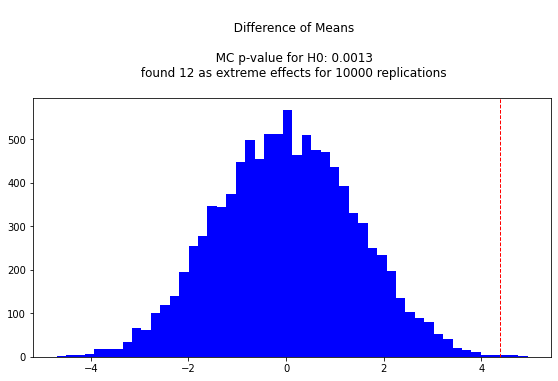

In [ ]:
# chosen test statistic
def diffMeans(x,y):
  return np.mean(x) - np.mean(y)

np.random.seed(121)
stats = resampling(10000, experiment, control, diffMeans)
present_results(stats, diffMeans(experiment, control), "Difference of Means")  

The red line identifies the observed effect.

The values have a direct probability interpretation: what is the probability that the experiment effect was due to chance? The answer is around $0.1\%$, which is strong evidence the measured effect is significant.

Let's try the same problem and check if the original data have a significant variance ratio:

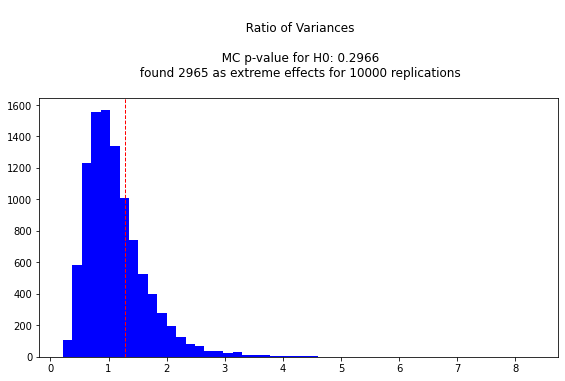

In [ ]:
def ratioVars(x,y):
  return np.var(x) / np.var(y)

np.random.seed(121)
stats = resampling(10000, experiment, control, ratioVars)
present_results(stats, ratioVars(experiment, control), "Ratio of Variances")  

The conclusion is that there is no good evidence the variance is different from the two groups in the original data.

The code is almost the same, we just replaced `diffMeans` with `ratioVars`.

On mainstream Statistics we would need [a completely different test](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances).



---



Let's compare this method with the mentioned pitfalls of classical hypothesis testing:

+ _each problem has a well-defined statistical procedure_: Resampling applies the same workflow to a large set of different problems. We just need to implement the stochastic model and the test statistic.

+ _assumptions required are subtle_ We need to assume collected data is modeled by random vars that are [iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), or at least [exchangeable](https://en.wikipedia.org/wiki/Exchangeable_random_variables) (i.e., all data permutations are equally probable under $H_0$). Some care must be taken if the two samples have different variance _and_ are quite dissimilar in size. However, no normality is required, and resampling is robust even if the two samples are modeled by different distributions.

+ _The p-value does not have a probabilistic interpretation_: the MC p-value has a probabilistic interpretation.

+ _statistical tests as algorithmic black boxes_: Here the computation is transparent. Everything needed is the stochastic model and the test statistic, which we both programmed.

If the simulation cannot be done - because it's too slow -, we must search for analytic shortcuts or other methods (but beware of their own simplifying assumptions).

Tests created with this methodology are usually called **permutation tests**.



---



## Bucket Statistics

Michael Wood [proposes](https://www.tandfonline.com/doi/full/10.1080/10691898.2005.11910562) a simulation model called _the two bucket story_. 

This model consists of two buckets (urns) containing balls. 

Given problem $P$, an universe $\Omega$ and a statistic $s$:

+ In bucket 1 each ball is a random sample $d$ taken repeatedly from $\Omega$ (with or without replacement) that represents an instance of $P$. Notice that a ball _represents an entire sample_.

+ In bucket 2, for each $d$, there is a ball with value $s(d)$ 

The contents of bucket2 are used to analyse the empirical distribution of $s$ and estimate an answer for $P$.

The next two functions are bucket factories. They must be parameterized depending on the problem.

In [ ]:
def makeBucket1(universe, withReplacement=False):
  def bucket1(sampleSize):
    return np.random.choice(universe, size=sampleSize, replace=withReplacement)

  return bucket1

def makeBucket2(bucket1, sampleSize, statistic):
  def bucket2(resamplingSize):
    result = np.zeros(resamplingSize).reshape(resamplingSize, 1)
    runBucket1 = lambda _ : statistic( bucket1(sampleSize) )
    return np.apply_along_axis(runBucket1, 1, result) 

  return bucket2  

Notice that what these factories return are functions that, when executed, produce a ball.

### Example -- The Birthday Paradox

We can use the two buckets model to estimate answers for the Birthday Paradox. 

> The birthday paradox, also known as the birthday problem, states that in a random group of 23 people, there is about a 50 percent chance that two people have the same birthday. Is this really true? [ref](https://www.scientificamerican.com/article/bring-science-home-probability-birthday-paradox/)

We sample from all possible anniversaries (here, integers from 1 to 366 representing days), and apply a statistic that checks for repeated values.

In [ ]:
nPeople = 23
days = np.arange(1,367)

# check for shared birthdays (returns 1 if shared birthdays, 0 otherwise)
def hasSharedValues(sample):
  return 1*(len(np.unique(sample)) != len(sample))

bucket1 = makeBucket1(days, True) # with replacement
bucket2 = makeBucket2(bucket1, nPeople, hasSharedValues)

np.mean(bucket2(10000)) 

0.5056

To consolidate our understanding of the procedure, let's check the outputs from both functions.

`bucket1` produces random samples of 23 anniversaries:

In [ ]:
print(bucket1(nPeople))
print(bucket1(nPeople))

[ 45 317 248 158 353  98  86 164 315 254  12 186 133 332 303   9 320  42
 190  41 138  44  88]
[123  42 261 356 205 360 183 185 149 131 218  67  49 316  65 240  49 273
 291 191 320   6 296]


While `bucket2` produces the result of checking if there are shared anniversaries, for a given number of experiments:

In [ ]:
print(bucket2(10)) # returns the result of 10 experiments

[1 1 0 1 0 0 1 0 0 0]


So, the mean of the results from bucket2 is an estimate for the previous question. We could easily check the results from bucket2 to answer other types of questions.

### Example -- A Poisson Problem

> Manchester United scored 80 goals in 38 matches in the 1998–9 English Premier League season, an average of 2.1 goals per match. What is the probability of MU of scoring 3 goals in one match during that season? -- Michael Wood's _Making Sense of Statistics_

38 matches of 90 minutes means a total of 3420 minutes. Let’s assume that all minutes during a match have a similar probability of getting goals and there’s no two goals within a minute (we can always model seconds instead of minutes). For the bucket model, each ball is a minute, and the Universe consists with 80 marked with a 1 for a goal (the 80 goals), or a zero for a non-goal (the remaining minutes).

In [ ]:
universe = np.concatenate((np.repeat(1,80), np.repeat(0,3420-80)))

bucket1 = makeBucket1(universe, False)
bucket2 = makeBucket2(bucket1, 90, np.sum) # a soccer match has 90 minutes

numGoals = 3
results = np.bincount( bucket2(10000) )    # computes a bin count, result[n] has total number of matches with n goals
print(np.round(results[numGoals] / sum(results),4))

0.1954


### Example -- Confidence Intervals for a Polling

A questionnaire was made with options from 0 (bad) to 5 (good). A total of 98 valid answers were collected. What is the $95\%$ confidence interval for the mean response?

| answer  | frequency  |
|:-:|:-:|
| 0 |42 |
| 1 |21 |
| 2 |16 |
| 3 | 6 |
| 4 | 9 |
| 5 | 4 |

In [ ]:
responses = [(0,42),(1,21),(2,16),(3,6),(4,9),(5,4)]
responses = np.array([val for val,freq in responses for _ in range(freq) ])

bucket1 = makeBucket1(responses, True)
bucket2 = makeBucket2(bucket1, len(responses), np.mean)

results = bucket2(10000) 
np.quantile(results, [.025, .975]) 

array([1.01020408, 1.60204082])

### Revisiting the t-test

Michael Wood says:

> There are, of course, many useful simulation approaches that do not fall under the umbrella of the two bucket story. One example is provided by approximate randomization tests (Noreen 1989; Wood 2003). These are randomization tests (Edgington 1995) which assess significance by “shuffling one variable … relative to another …” (Noreen 1989, page 9). This is a general simulation method that can often be used as a substitute for a number of traditional hypothesis tests — t test, one way analysis of variance, test of the hypothesis that a correlation is zero, Mann-Whitney test, etc. However, it does not fit the format of the two bucket story—it would need a third bucket so that two buckets can be reserved for the data allowing them to be “shuffled” relative to each other.

However, *it is* possible to use the two bucket story for making a t-test (and other tests, as we will see).

Consider the previous experiment/control data:

In [ ]:
experiment = np.array([27,20,21,26,27,31,24,21,20,19,23,24,28,19,24,29,18,20,17,31,20,25,28,21,27])
control    = np.array([21,22,15,12,21,16,19,15,22,24,19,23,13,22,20,24,18,20])

allData = np.concatenate((experiment, control))

What bucket1 will be sampling _are the indices of the entire data_. For each index permutation, we compute the difference of means for the two resampled groups. To achieve that, we just take the first indices and assign them to the first group, and do the same to the second group.

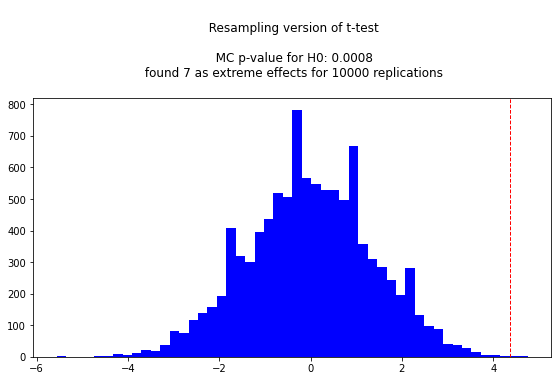

In [ ]:
def diffMeans(indices):
  indicesGroup1 = indices[:len(experiment)]
  indicesGroup2 = indices[len(experiment):]
  return np.mean(allData[indicesGroup1]) - np.mean(allData[indicesGroup2])

bucket1 = makeBucket1(np.arange(0,len(allData)), False)
bucket2 = makeBucket2(bucket1, len(allData), diffMeans)

results = bucket2(10000)

observedEffect = np.mean(experiment) - np.mean(control)
present_results(results, observedEffect, "Resampling version of t-test")

### Replacing the $\chi^2$-Test

> Suppose you run a casino and you suspect that a customer has replaced a die provided by the casino with a ``crooked die''; that is, one that has been tampered with to make one of the faces more likely to come up than the others.  You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.  You roll the die 60 times and get the following results: 

| Value  |  Frequency |
|:------:|:----------:|
|   1    |      8     |
|   2    |      9     |
|   3    |     19     |
|   4    |      6     |
|   5    |      8     |
|   6    |     10     |

> What is the probability of seeing results like this by chance?


In [ ]:
experiment = [(1,8),(2,9),(3,19),(4,6),(5,8),(6,10)]
experiment = np.array([val for val,freq in experiment for _ in range(freq) ])

The standard test statistic here is the $\chi^2$:

> The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories -- [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_test)

In [ ]:
expected = np.repeat(1/6,6)  # the most probable distribution for a fair die

def chiSquared(sample):
  # we need to find the empirical distribution of the sample 
  # in order to compare with the expected distribution
  sample = np.append(sample, [1,2,3,4,5,6])  # add one of each to prevent zero counts
  sampleCount = np.bincount(sample)
  sampleCount = sampleCount - 1              # bincount already done, remove one of each
  sampleCount = sampleCount / sum(sampleCount) 
  return np.sum((sampleCount[1:]-expected)**2/expected)

So, the first bucket will generate samples of 60 dice throws. The second bucket will take each sample and apply the chi-squared statistic.

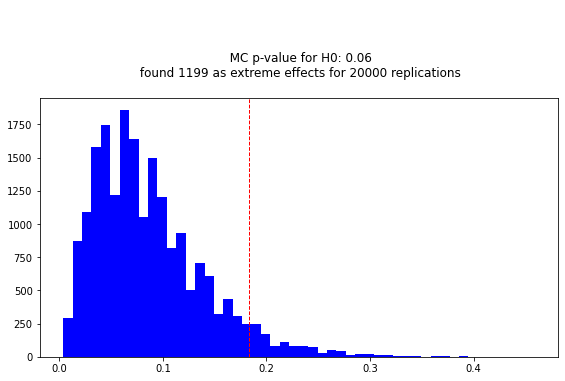

In [ ]:
bucket1 = makeBucket1(np.array([1,2,3,4,5,6]), True)
bucket2 = makeBucket2(bucket1, len(experiment), chiSquared)

results = bucket2(20000)

observedEffect = chiSquared(experiment)
present_results(results, observedEffect)

There is weak evidence that the dice might not be fair (the evidence would be stronger if the observed effect was farther into the tail).

Comparing with the classical statistical test we find a similar p-value:

In [ ]:
observed = np.array([8,9,19,6,8,10])
ss.chisquare(observed, np.repeat(np.sum(observed)/6,6))

Power_divergenceResult(statistic=10.6, pvalue=0.05991362580421519)

### Replacing the Mann-Whitney U-Test

The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

> The two samples are combined and rank ordered together. The strategy is to determine if the values from the two samples are randomly mixed in the rank ordering or if they are clustered at opposite ends when combined. A random rank order would mean that the two samples are not different, while a cluster of one sample values would indicate a difference between them. – pg.58, Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach, 2009.


Some data:

In [ ]:
group1 = np.array([20, 23, 21, 25, 18, 17, 18, 24, 20, 24, 23, 19])
group2 = np.array([24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23])

allData = np.concatenate((group1, group2)) 

The test statistic `statU` checks the difference between the sum of ranks of the two groups of data:

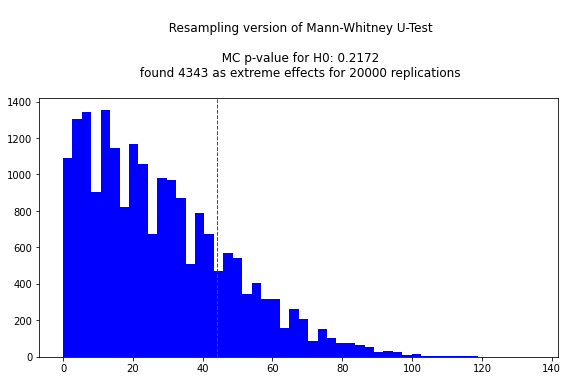

In [ ]:
sizeGroup1 = len(group1)

def statU(sample):
  ranks = ss.rankdata(sample)
  return np.absolute( np.sum(ranks[0:sizeGroup1]) - np.sum(ranks[sizeGroup1:]) )

bucket1 = makeBucket1(allData)
bucket2 = makeBucket2(bucket1, len(allData), statU)

results = bucket2(20000)

observedEffect = statU(allData)
present_results(results, observedEffect, "Resampling version of Mann-Whitney U-Test")

So, there's very weak evidence that the differences between the two groups are significant.

Comparing with the standard statistical test we again find a similar p-value:

In [ ]:
ss.mannwhitneyu(group1, group2, alternative='two-sided')

MannwhitneyuResult(statistic=50.0, pvalue=0.21138945901258455)

### Replacing the Dependent Sample t-test

The following data consists of the points earned at a 2017 diving competition for 12 athletes.

We would like to check if the point differences between semifinal and final are due to chance, or is there some effect happening.

This can be handled as a difference of means. However, the _data is not independent_. These are paired values from the same athlete!

In [ ]:
           # athlete1 vvvvvv  
semifinal = np.array([325.50, 382.80, 367.50, 346.00, 318.70, 360.85, 313.70, 355.15, 322.75, 320.55, 322.75, 325.75])
final     = np.array([397.50, 396.00, 391.95, 385.55, 370.20, 360.00, 357.85, 331.40, 322.40, 307.15, 302.35, 283.35])
           # athlete1 ^^^^^^

In this case, we need to swap the points randomly, for each athlete, at each resampling. That is we only swap the values between both lists at the same index. 

Bucket1 will provide samples, not of athlete's points, but of swaps (-1 to swap the points of an athlete, +1 to keep as is).

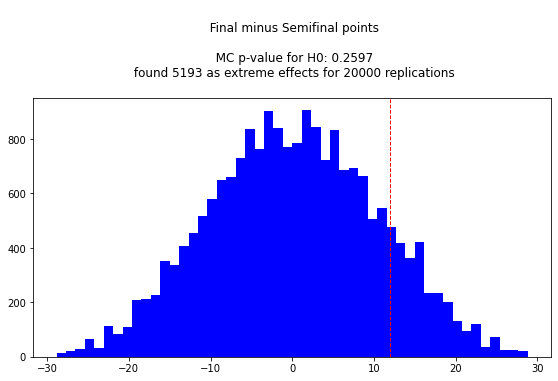

In [ ]:
def diffMeansMatched(swaps):
  return np.mean((final - semifinal) * swaps)

bucket1 = makeBucket1([-1,1], True)  # generate random list of +1s/-1s
bucket2 = makeBucket2(bucket1, len(final), diffMeansMatched)

results = bucket2(20000)

observedEffect = np.mean(final - semifinal)
present_results(results, observedEffect, "Final minus Semifinal points")

So the results state that chance alone could account for the point differences between final and semifinal.

Let's check the equivalent frequencist test, the dependent sample t-test:

In [ ]:
ss.ttest_rel(semifinal, final)

Ttest_relResult(statistic=-1.1903390385665338, pvalue=0.25896840383393227)

Again we find a similar p-value result.

### Replacing the Wilcoxon Test Statistic

Another method for dependend observations is called the Wilcoxon Test Statistic:

In [ ]:
def wilcoxon(swaps):
  # apply swaps 
  xs, ys = np.array(semifinal), np.array(final)
  for i,swap in enumerate(swaps):
    if swap == -1:
      xs[i], ys[i] = ys[i], xs[i]
  # compute statistic
  # ref: https://www.investopedia.com/terms/w/wilcoxon-test.asp
  diffs = xs-ys                           # obtain a difference score
  diffs = diffs[diffs != 0]               # remove zeros
  signs = 1 - 2*(diffs < 0)               # save signs of differences
  ranks = ss.rankdata(np.absolute(diffs)) # rank scores
  result = signs * ranks                  # assign signs to ranks
  return np.sum(result[result > 0])       # return sum of the positive ranks

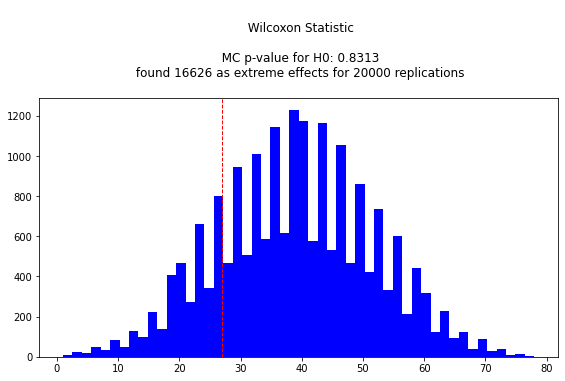

In [ ]:
bucket1 = makeBucket1([-1,1], True)  # generate random list of +1s/-1s
bucket2 = makeBucket2(bucket1, len(final), wilcoxon)

results = bucket2(20_000)

observedEffect = wilcoxon([1]*len(final))
present_results(results, observedEffect, "Wilcoxon Statistic")

Here the p-value from the frequentist:

In [ ]:
ss.wilcoxon(semifinal, final, alternative="greater")

WilcoxonResult(statistic=27.0, pvalue=0.830322265625)

### Testing Effects in Contingency Tables

Sometimes we have a contingency table showing the changes of proportions before and after applying some treatment.

Here's an example:

In [ ]:
table = [[30, 20], # number of yes and no before effect
         [10, 40]] # number of yes and no after effect

We can get a response with resampling by considering the proportions before the effect to make an universe. We will test if the new result is surprising if the initial proportion remain constant.

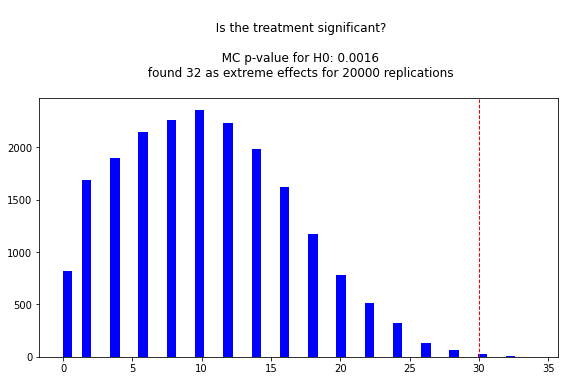

In [ ]:
universe = np.concatenate((np.repeat(1, table[0][0]), 
                           np.repeat(0, table[0][1])))

def diff(xs):  # check the difference between #yes and #no
  return abs(np.sum(xs==0)-np.sum(xs==1))
  
bucket1 = makeBucket1(universe, True)
bucket2 = makeBucket2(bucket1, sum(table[0]), diff)

results = bucket2(20_000)

observedEffect = abs(table[1][0] - table[1][1])
present_results(results, observedEffect, "Is the treatment significant?")

The test says the result is significant with a MC p-value of around $0.002$.

### About McNemar’s Test 

The previous contigency table can be interpreted in a different way.

Assume we applied two different tests on the same group of persons, and wish to compare if their sensitivity and specificity are significantly different. [McNemar's test](https://en.wikipedia.org/wiki/McNemar%27s_test#Examples) is used in this setting, by testing if the amount of people that was positive in one and negative in the other, and vice-versa, is around the same.

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
# exact = False uses the Chi-Square distribution (used in function mcnemar below)
print(mcnemar(table, exact=False, correction=False))

pvalue      0.06788915486182893
statistic   3.3333333333333335


We can apply the same sampling as before, but changing the statistic accordingly:

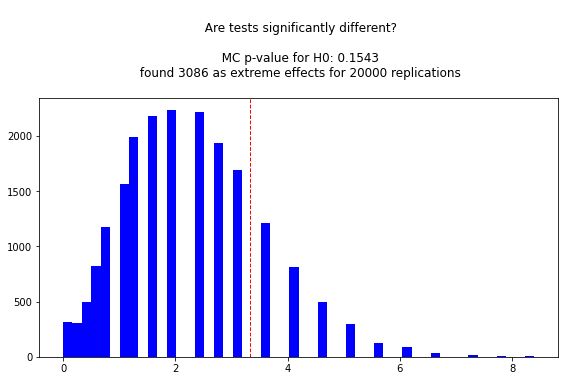

In [ ]:
def mcnemar(xs):
  b = table[0][1]
  c = sum(xs)
  return (b-c)**2 / (b+c)

bucket2 = makeBucket2(bucket1, sum(table[0]), mcnemar)

results = bucket2(20_000)

observedEffect = mcnemar(np.repeat(1, table[1][0]))
present_results(results, observedEffect, "Are tests significantly different?")

Here, the resampling assigns more uncertainty to the comparison.

## Bootstrap

The bootstrap uses Monte Carlo simulations to resample many datasets based on the original data. These resamples are used to measure the variation of a given test statistic. The bootstrap assumes that the different observations from the sample are independent and that the sample contains sufficient information about the population.

Within the two bucket model, the 'bootstraper' for a given `sample` is the function returned by `makeBucket1(sample, True)`.

Here's a simple eg: we have a sample of size 50 from a population modeled by a $\mathcal{N}(3,2^2)$ distribution.

In [ ]:
np.random.seed(123)
sampleSize = 50
sample = 3 + 2 * np.random.randn(sampleSize)

In practice we don't know the population distribution (otherwise, the bootstrap would not be needed), but let’s assume that in order to compare results. Say, we wish to find out about the variation of its mean:

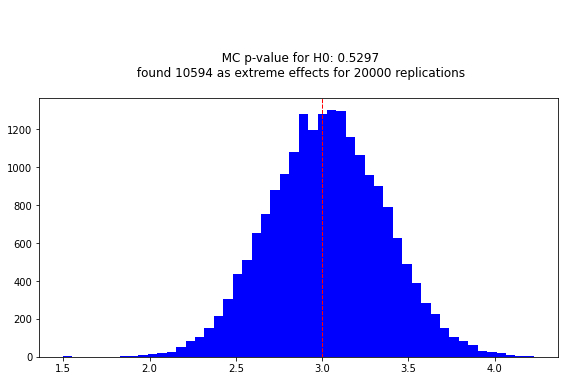

In [ ]:
bucket1 = makeBucket1(sample, True)
bucket2 = makeBucket2(bucket1, sampleSize, np.mean)

bootstrapSamples = bucket2(20000)

present_results(bootstrapSamples, 3)

We are still using the two bucket model, but we are answering a different question. We are no longer testing an hypothesis, but measuring the variation of some sample statistic (in the previous example, the sample's mean).

Since I'm reusing the plotting function to a different type of problem, the printed 'p-value' does not have the interpretation it had in hypothesis testing (there's no p-value here, now it's just a percentile for the observed effect, i.e, the mean, which should be around 50%).

Consider the following picture (from wikipedia):

<center><img src='https://raw.githubusercontent.com/jpneto/topicsInPython/main/imgs/Accuracy_and_precision.wikipedia.png' width=500px></center>

The bootstrap gives us an estimation of the **precision**, how thin or large is the empirical distribution produced by the resampling procedure. Precision is a measure of closeness between values and it is usually determined by the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) formula.

A more important measure is **accuracy**, because it relates to systematic errors, not statistical errors. Unfortunately, this is difficult to access since we don't know how the system we are studying really works (that's what motivates the study in the first place). The best thing is to follow good practices in collecting representative data to minimize this type of problem.

In Statistics these concepts are usually named [variance and bias](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

Allen Downey's next diagram shows the similarities and differences between using resampling for test hypothesis and measuring variability [ref](https://nbviewer.jupyter.org/github/AllenDowney/ElementsOfDataScience/blob/master/11_inference.ipynb):

<br><center><img src='https://raw.githubusercontent.com/jpneto/topicsInPython/main/imgs/resampling.allen.downey.png' width=600px></center>

Herein, the population model is provided by the bootstrap procedure based on the original sample.

### Example -- Bootstrapping Regression Models

We can apply the buckets to perform a bootstrap to compute confidence intervals for the coefficients of a linear regression or other similar models. There are two standard methods:

+ _Observation resampling_: bootstrap the data and collect all coefficients obtained by applying the regression to each resample (so the data is seen as random).

+ _Residual resampling_: treat the data as fixed and apply the resampling at the residuals.

Let's show an example of this second method.

In [ ]:
### make some data
np.random.seed(101)
x = np.linspace(0, 10, 30)
y = 3*x + 1 + 2.5*np.random.normal(size=len(x))

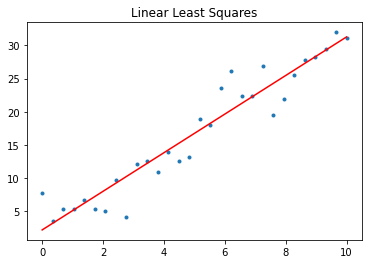

In [ ]:
### The Linear Regression
slope, intercept, *_ = ss.linregress(x,y)
yhat = x * slope + intercept

plt.title("Linear Least Squares")
plt.scatter(x, y, marker='.')
plt.plot(x, yhat, color='red')
plt.show()

The resampling becomes:

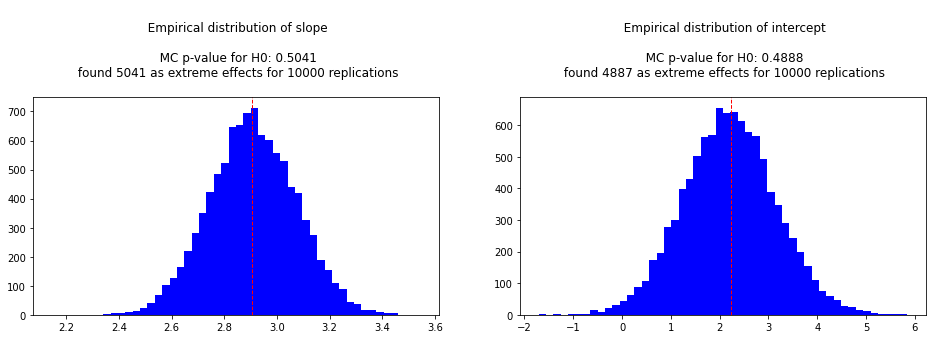

In [ ]:
# the test statistic outputs pair (slope, intercept) 
# for a given resampling of the original residuals
def linregress(residuals):
  yhat_boot = yhat + residuals
  slope, intercept, *_ = ss.linregress(x, yhat_boot)
  return (slope, intercept)

residuals = y - yhat

bucket1 = makeBucket1(residuals, True)
bucket2 = makeBucket2(bucket1, len(residuals), linregress)

results = bucket2(10000)

slopes     = [ s for (s,_) in results]
intercepts = [ i for (_,i) in results]

fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
present_results(slopes,     slope,     "Empirical distribution of slope"    , axes=axes[0])
present_results(intercepts, intercept, "Empirical distribution of intercept", axes=axes[1])

Herein, the percentile value near $50\%$ informs us that the bootstrap produced balanced results around the regression coefficients.



---



### Example - Signal/Noise Variable Detection

Let's say we have data with two independent variables, $x_1, x_2$ and one dependent $y$. Before doing some classification or regression, we wish to check if variables $x_i$ have some significant signal in $y$.

In [ ]:
np.random.seed(101)
n  = 100

# In this example, x1 is just noise, x2 has signal
x1 = np.array(np.random.normal(size=n)) 
x2 = np.array(np.random.normal(size=n))
y  = (2*x2 + np.random.normal(0,0.5,size=n)) > 0

In this example, $x_2$ is a variable with signal while $x_1$ is pure noise.

The chosen statistic here is the [deviance](https://en.wikipedia.org/wiki/Deviance_(statistics)) which is a measure of model fitness,

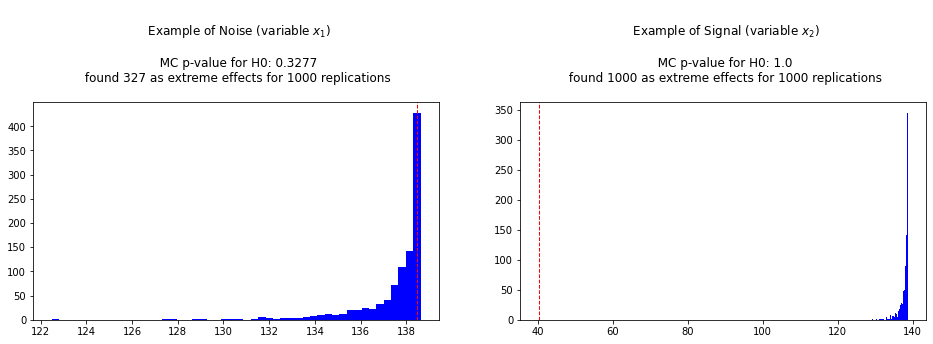

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def deviance(x, y, model):
    return 2*log_loss(y, model.predict_proba(x), normalize=False)

# the test statistic, returns deviance for model fitted with sample x
def statDeviance(x):  
  x_ = x.reshape(-1,1)
  model = LogisticRegression().fit(x_, y)
  return deviance(x_, y, model)

fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)

# check first variable
bucket1 = makeBucket1(x1, True)
bucket2 = makeBucket2(bucket1, len(x1), statDeviance)  

observedEffect = statDeviance(x1)
results = bucket2(1000)
present_results(results, observedEffect, "Example of Noise (variable $x_1$)", axes=axes[0])

# check second variable
bucket1 = makeBucket1(x2, True)
bucket2 = makeBucket2(bucket1, len(x2), statDeviance)  

observedEffect = statDeviance(x2)
results = bucket2(1000)
present_results(results, observedEffect, "Example of Signal (variable $x_2$)", axes=axes[1])

If a variable has signal over $y$ then the model fitted with real data will perform much better (will have lower deviance) than models with resampled data. 

If a variable is noise, then its deviance will be within the range of deviances from the models with resampled data. 

This method can be used with other metrics, like accuracy or recall for classifiers, or squared error for regressions.

This can also be applied to set of variables, where the resampling occurs in more than one column.



---



## References

+ Michael Wood -- Making Sense of Statistics, A Non-Mathematical Approach, 2003

+ Michael Wood -- [The Role of Simulation Approaches in Statistics](https://www.tandfonline.com/doi/full/10.1080/10691898.2005.11910562), 2005

+ George Cobb -- [The Introductory Statistics Course: A Ptolemaic Curriculum?](https://escholarship.org/uc/item/6hb3k0nz), 2007

+ Allen Downey -- [There is still only one test ](https://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html), 2011, 2016

+ Nina Zumel -- [How Do You Know if Your Data Has Signal?](https://win-vector.com/2015/08/10/how-do-you-know-if-your-data-has-signal/), 2015

+ Allen Downey -- [Inference, Elements of Data Science](https://nbviewer.jupyter.org/github/AllenDowney/ElementsOfDataScience/blob/master/11_inference.ipynb), 2019

+ João Neto -- [Bucket Statistics](http://www.di.fc.ul.pt/~jpn/r/bootstrap/buckets.html) and [Statistics with Resampling](http://www.di.fc.ul.pt/~jpn/r/bootstrap/stat_resampling.html); (R notebooks)